In [2]:
import json, glob, yt, os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

from analysis_helpers import *

%matplotlib inline


In [4]:
sim = 'ph*'
orig_files = glob.glob('/home/darksky/Projects/phoenix_analysis/p2_origins/%s/*p2_origin_qtys.json'%sim)
with open(orig_files[0],'r') as f:
    enr = json.load(f)
for i,ofile in enumerate(orig_files):
    if i == 0: continue
    with open(ofile, 'r') as f:
        data = json.load(f)
    for k in data.keys(): 
        if type(data[k]) != dict:
            # then append to the current dicts keys
            # print(k)
            enr[k] += data[k]
        elif k == 'p3_stats': # enr['p3_stats'][p3idx][key]
            for kk in data[k].keys(): # for idx in p3idx's
                if kk in enr[k].keys(): # append to preexisting p3idx
                    for j in enr[k][kk].keys():
                       enr[k][kk][j] += data[k][kk][j]
                else: # establish the p3idx
                    enr[k][kk] = data[k][kk]

        else: # then its enr[k][index][qty list]
            # print(k)
            for kk in data[k].keys(): # indexes
                if kk in enr[k].keys(): # then append
                    enr[k][kk] += data[k][kk] 
                else: # then create
                    enr[k][kk] = data[k][kk]

In [9]:
simpaths = ['/home/darksky/Projects/enzo_sim/phoenix/phx256-%d'%d for d in [1,2]] #+ ['D:/starnet/simulation_data/phx512']
fouts = ['RD1250','RD1100']
zbins = np.linspace(-7,3,100)
p2zs = None
for s, fout in zip(simpaths, fouts):
    ds = yt.load('%s/%s/%s'%(s, fout, fout))
    ds = add_particle_filters(ds)
    ad = ds.all_data()
    if p2zs:
        p2zs += [[float(z)] * int(ad['p2_stars','particle_mass'][i].to("Msun")) for i, z in enumerate(ad['p2_stars','metallicity_fraction'].to('Zsun'))]
    else:
        p2zs = [[float(z)] * int(ad['p2_stars','particle_mass'][i].to("Msun")) for i, z in enumerate(ad['p2_stars','metallicity_fraction'].to('Zsun'))]

p2zs = np.array(p2zs).flatten()



yt : [INFO     ] 2021-10-04 11:38:13,539 Parameters: current_time              = 16.548159927217
yt : [INFO     ] 2021-10-04 11:38:13,541 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2021-10-04 11:38:13,543 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-10-04 11:38:13,544 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-10-04 11:38:13,544 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-10-04 11:38:13,545 Parameters: current_redshift          = 12.451325487595
yt : [INFO     ] 2021-10-04 11:38:13,545 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2021-10-04 11:38:13,546 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2021-10-04 11:38:13,546 Parameters: omega_radiation           = 0
yt : [INFO     ] 2021-10-04 11:38:13,547 Parameters: hubble_constant           = 0.6766
Parsing Hierarchy : 100%|██████████| 27260/27260 [00:06<00:00, 4269.29it/s]
yt : [INFO     ] 2021

TypeError: loop of ufunc does not support argument 0 of type list which has no callable log10 method

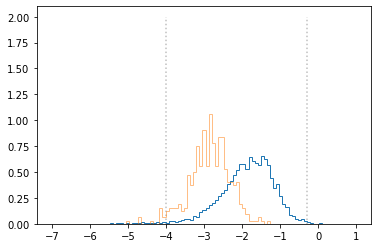

In [11]:
sim = 'phx-all'
zbins = np.linspace(-7,1,100)
uni_inds = []
uni_pids = []
if os.path.exists('low_metallicity_p2_idx.log'):
    with open('low_metallicity_p2_idx.log','w') as f:
            f.write('##\n')
    with open('high_metallicity_p2_idx.log','w') as f:
            f.write('##\n')
    
for i, pid in enumerate(enr['enrichee_pidx']):
    if pid not in uni_pids:
        if np.log10(enr['enrichee_metal'][i]) < -4.:
#             print("%d has low metallicity!"%pid)
            with open('low_metallicity_p2_idx.log','a') as f:
                f.write('%d\n'%pid)
        if np.log10(enr['enrichee_metal'][i]) > -0.3:
#             print("%d has high metallicity!"%pid)
            with open('high_metallicity_p2_idx.log','a') as f:
                f.write('%d\n'%pid)
            
        uni_inds.append(i)
        uni_pids.append(pid)
fig, ax = plt.subplots()
ax.vlines([-4, -0.3], 1e-6, 2, linestyle=':', color='tab:grey', alpha=0.5)
ax.hist(np.log10(ds.arr(enr['enrichee_metal'], 'Zsun').to('Zsun')[uni_inds]), 
                    bins=zbins, 
                    density=True, 
                    histtype='step', 
                    label='2G')

with open('low_z_observed_stars.json','r') as f:
    lowz = json.load(f)
feh = []
for i in range(len(lowz['data'])):
    if type(lowz['data'][i]['Fe/H']) == str:
        app = float(lowz['data'][i]['Fe/H'][1:])
    else:
        app = float(lowz['data'][i]['Fe/H'])
    feh.append(app)
ax.hist([i for i in feh], bins=zbins, density=True, alpha=0.5, label='Lit', histtype='step')
ax.hist(np.log10(p2zs), bins=zbins, density=True, histtype='stepfilled', label='PII', alpha=0.5)
ax.set_yscale('log')
ax.set_ylim(5e-4, 1.1)
ax.legend()
ax.set_xlabel('$Z$')
ax.set_ylabel('d$N$/d$Z$')
plt.savefig('p2_origins/%s_p2_MDF.pdf'%sim)
twog = np.log10(ds.arr(enr['enrichee_metal'], 'Zsun'))
p2 = np.log10(p2zs)
print('Mean, min, max:\n\t2g: %0.2f, %0.2f, %0.2f, %0.2f\n\tP2: %0.2f, %0.2f, %0.2f, %0.2f'\
         %(twog.mean(), twog.min(), twog.max(), twog.std(), 
           p2.mean(), p2.min(), p2.max(), p2.std()))

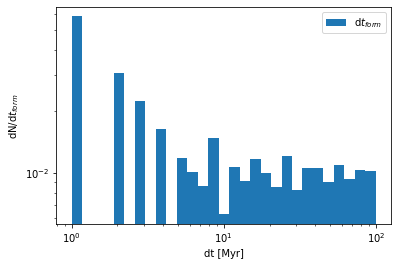

In [8]:
fig, ax = plt.subplots()
bins = np.logspace(0, 2, 30)
ax.hist(enr['formation_dt'], label=['d$t_{form}$','d$t_{sne}$'], bins=bins, density=True)
# ax.hist(enr['sne_dt'], label='d$t_{sne}$', bins=25, color='tab:orange', alpha=0.5, density=True, range=[0,110])
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('dt [Myr]')
ax.set_ylabel('dN/d$t_{form}$')
ax.set_yscale('log')
plt.savefig('p2_origins/%s_dt_toP2.pdf'%sim)


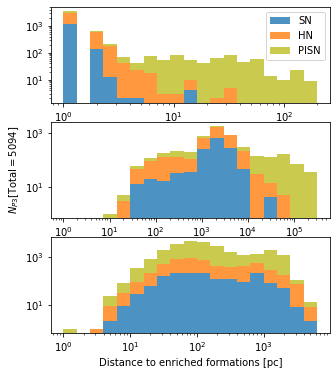

In [ ]:
sim='phxall'
fig, ax = plt.subplots(3,1, figsize=(5,6))
# num_enr = []
# m_enr = []
# r_enr = []

num_sne = [[],[],[]]
m_sne = [[],[],[]]
r_sne = [[],[],[]]
n_rem = 0
for i, k in enumerate(enr['p3_stats'].keys()):
    # num_enr += [enr['p3_stats'][k]['n_enriched']]
    # m_enr += [enr['p3_stats'][k]['m_enriched']]
    # r_enr += [enr['p3_stats'][k]['r_enriched']]
    m = enr['p3_stats'][k]['mass']
    if (m > 11) and (m < 20):
        bin = 0
    elif (m >= 20) and (m < 40):
        bin = 1
    elif (m >=140) and (m < 260):
        bin = 2
    else:
        continue
    n_rem += 1
    num_sne[bin].append(enr['p3_stats'][k]['n_enriched'])
    m_sne[bin].append(enr['p3_stats'][k]['m_enriched'])
    for rad in enr['p3_stats'][k]['r_enriched']:
        r_sne[bin].append(rad)



# ax[0][0].hist(num_enr, bins=10, label='N_{enriched}', density = False)
# ax[1][0].hist(m_enr, bins=10, label='Enriched Mass', density=False)
# ax[2][0].hist(r_enr, bins=15, label='Event distance', density=False)
numbins = np.logspace(0,2.3,20)
massbins = np.logspace(0,5.5, 20)
rbins = np.logspace(0,3.8, 20)
sne_kind = {0:'SN', 1:'HN', 2:'PISN'}
# for type in [0,1,2]:
ax[0].hist(num_sne, bins=numbins, label=['SN','HN','PISN'], density=False, alpha=0.8, stacked=True, color=['tab:blue','tab:orange','tab:olive'])
ax[1].hist(m_sne, bins=massbins, density=False, alpha=0.8, stacked=True, color=['tab:blue','tab:orange','tab:olive'])
ax[2].hist(r_sne, bins=rbins, density=False, alpha=0.8, stacked=True, color=['tab:blue','tab:orange','tab:olive'])
ax[0].legend()
ax[0].set_xlabel('Number of enriched formations')
ax[1].set_xlabel('Total ensuing mass [M$_\odot$]')
ax[2].set_xlabel('Distance to enriched formations [pc]')
ax[2].set_yscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel('$N_{P3} [{\\rm Total} =%d]$'%n_rem)
for a in ax:
    a.set_xscale('log')
plt.savefig('p2_origins/%s_SNeffect.pdf'%sim)




In [6]:
# plot sne, hne, pisn only enrichment
# sne-hne, sne-pisn, sne-hne, hne-pisn, sne-hne-pisn
ds= yt.load("C:/Users/azton/Projects/phoenix/phx256-1/RD1250/RD1250")
labels = ['SN','HN','PISN','SN-HN','SN-PISN','HN-PISN','SN-HN-PISN']
counts = [0, 0, 0, 0, 0, 0, 0]
radii = [[] for c in counts]
nenrichers = [[] for c in counts]
r_enrichers = [[] for c in counts]
p2metals = [[] for c in counts]
mass_enr = [[] for c in counts]
enrichers = []
n_formed = 0
n_smallr = 0
tot_iter = 0
for i, id in enumerate(enr['enricher_mass'].keys()):
    this_enr = [0,0,0]
    n_formed += 1
    mt = 0
    for ii,m in enumerate(enr['enricher_mass'][id]):
        # print('%0.2f'%m, end=' ')
        good_mass = (m > 11 and m <= 20) or (m>20 and m <= 40) or (m > 140 and m < 260)
                # check that distance / velocity < time since sne
        try:
            enr_dist = enr['distance'][id][ii]
        except IndexError as ie:
            print('enr_dist_len = %d; i = %d'%(len(enr['distance'][id]), ii))
            print('enr_dist = ', enr['distance'][id])
            print('enr_mass = ', enr['enricher_mass'][id])
        enr_dt = enr['sne_dt'][id][ii]
        tot_iter += 1
        c_ism = 10
        if  ds.quan(enr_dist, 'pc').to('km') / (ds.quan(enr_dt, 'Myr').to('s') * ds.quan(c_ism, 'km/s')) >= 100 \
                and good_mass\
                and enr_dist > 200:
            print('%dth of %s appears to not have enrichment radius to meet creation. r = %f; dt = %f, ratio= %0.2e'%\
                (ii, id,enr_dist, enr_dt, ds.quan(enr_dist, 'pc').to('km') / (ds.quan(enr_dt, 'Myr').to('s') * ds.quan(c_ism, 'km/s'))))
            n_smallr+=1
            continue
        if enr_dt < 0: continue
            
        if m > 11 and m <= 20:
            this_enr[0] += 1
            mt += m
            good_mass = True
        elif m > 20 and m < 40.0059:
            this_enr[1] += 1
            mt += m
            good_mass = True
        elif m >140 and m < 260:
            this_enr[2] += 1
            mt += m
            good_mass = True

    
    binid = [1 if i > 0 else 0 for i in this_enr]
    this_enr = binid
    # print('\n\n')
    if this_enr == [1,0,0]: # SNE
        mass_enr[0] .append(mt)
        counts[0] += 1
        radii[0] += enr['distance'][id]
        nenrichers[0].append(len(enr['distance'][id]))
        r_enrichers[0].append(np.average(enr['distance'][id]))
        p2metals[0].append(enr['enrichee_metal'][i])
    elif this_enr == [0,1,0]: # HNE
        mass_enr[1] .append(mt)
        counts[1] += 1
        radii[1] += enr['distance'][id]
        r_enrichers[1].append(np.average(enr['distance'][id]))
        p2metals[1].append(enr['enrichee_metal'][i])
        nenrichers[1].append(len(enr['distance'][id]))
    elif this_enr == [0,0,1]: # PISN
        mass_enr[2] .append(mt)
        counts[2] += 1
        radii[2] += enr['distance'][id]
        nenrichers[2].append(len(enr['distance'][id]))
        r_enrichers[2].append(np.average(enr['distance'][id]))
        p2metals[2].append(enr['enrichee_metal'][i])
    elif this_enr == [1,1,0]: # SN+HN
        mass_enr[3] .append(mt)
        counts[3] += 1
        radii[3] += enr['distance'][id]
        nenrichers[3].append(len(enr['distance'][id]))
        r_enrichers[3].append(np.average(enr['distance'][id]))
        p2metals[3].append(enr['enrichee_metal'][i])
    elif this_enr == [1,0,1]: # SN + PISN
        mass_enr[4].append(mt)
        counts[4] += 1
        radii[4] += enr['distance'][id]
        nenrichers[4].append(len(enr['distance'][id]))
        r_enrichers[4].append(np.average(enr['distance'][id]))
        p2metals[4].append(enr['enrichee_metal'][i])
    elif this_enr == [0, 1, 1]: # HN + PISN
        mass_enr[5] .append(mt)
        counts[5] += 1
        radii[5] += enr['distance'][id]
        nenrichers[5].append(len(enr['distance'][id]))
        r_enrichers[5].append(np.average(enr['distance'][id]))
        p2metals[5].append(enr['enrichee_metal'][i])
    elif this_enr == [1,1,1]: # ALL
        mass_enr[6] .append(mt)
        counts[6] += 1
        radii[6] += enr['distance'][id]
        nenrichers[6].append(len(enr['distance'][id]))
        r_enrichers[6].append(np.average(enr['distance'][id]))
        p2metals[6].append(enr['enrichee_metal'][i])
print("%d/%d seem too small to affect formation"%(n_smallr, tot_iter))

yt : [INFO     ] 2021-09-20 10:31:41,235 Parameters: current_time              = 16.548159927217
yt : [INFO     ] 2021-09-20 10:31:41,235 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2021-09-20 10:31:41,236 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-09-20 10:31:41,237 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-09-20 10:31:41,238 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-09-20 10:31:41,238 Parameters: current_redshift          = 12.451325487595
yt : [INFO     ] 2021-09-20 10:31:41,238 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2021-09-20 10:31:41,239 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2021-09-20 10:31:41,239 Parameters: omega_radiation           = 0
yt : [INFO     ] 2021-09-20 10:31:41,239 Parameters: hubble_constant           = 0.6766


2th of 134464844 appears to not have enrichment radius to meet creation. r = 273.583872; dt = 0.252984, ratio= 1.06e+02
3th of 134464844 appears to not have enrichment radius to meet creation. r = 273.467802; dt = 0.103217, ratio= 2.59e+02
25th of 134512872 appears to not have enrichment radius to meet creation. r = 351.907865; dt = 0.058735, ratio= 5.86e+02
26th of 134512872 appears to not have enrichment radius to meet creation. r = 391.449541; dt = 0.155274, ratio= 2.47e+02
12th of 134513002 appears to not have enrichment radius to meet creation. r = 458.294812; dt = 0.432573, ratio= 1.04e+02
24th of 135535022 appears to not have enrichment radius to meet creation. r = 404.522269; dt = 0.223607, ratio= 1.77e+02
24th of 135565954 appears to not have enrichment radius to meet creation. r = 421.122472; dt = 0.223607, ratio= 1.84e+02
24th of 135569741 appears to not have enrichment radius to meet creation. r = 408.528322; dt = 0.223607, ratio= 1.79e+02
20th of 135591933 appears to not h

Counts/bin [33, 383, 946, 1034, 20, 291, 2736] 5443
$N_{\rm PII} = $5443; $N_{\rm PIII} = $73523


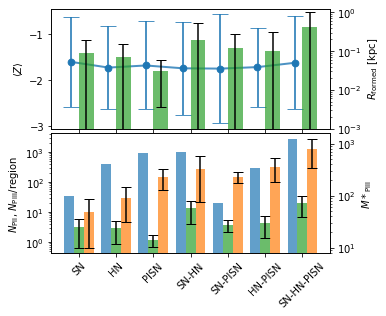

In [7]:
counts_bin = [len(r) for r in mass_enr]
counts_sum = sum(counts_bin)
counts_p3 = [len(r) for r in radii]
print('Counts/bin', counts_bin, counts_sum)
means = np.array([np.average(r) if len(r) > 0 else 0 for r in radii])
minr = np.array([min(r) if len(r) > 0 else 0 for r in radii])
maxr = np.array([max(r) if len(r) > 0 else 0 for r in radii])
stdr = np.array([np.std(r) if len(r) > 0 else 0 for r in radii])

mean_n = [np.average(n) if len(n) > 0 else 0 for n in nenrichers]
std_n = [np.std(n) if len(n) > 0 else 0 for n in nenrichers]

mean_z = np.log10([np.average(z) if len(z) > 0 else 0 for z in p2metals])
std_z = np.array([np.std(np.log10(z)) if len(z) > 0 else 0 for z in p2metals])
# min_z = np.array([min(z) if len(z) > 0 else 0 for z in p2metals])

mform = np.array([np.average(m) if len(m) > 0 else 0 for m in mass_enr])
mmax = np.array([max(m) if len(m) > 0 else 0 for m in mass_enr])
mmin = np.array([min(m) if len(m) > 0 else 0 for m in mass_enr])
mstd = np.array([np.std(m) if len(m) > 0 else 0 for m in mass_enr])

fig, ax = plt.subplots(2,1, figsize=(5,4.5), sharex=True)
axt = ax[0].twinx()
print('$N_{\\rm PII} = $%d; $N_{\\rm PIII} = $%d'%(counts_sum, sum(counts_p3)))

label_loc = np.arange(len(labels))
width=0.8/2.0
ax[0].errorbar(label_loc-0.2, mean_z,
#                 tick_label=labels,
                alpha=0.8,
#                 width=-1*width,
                yerr=std_z,
                capsize=8,
#                 align='edge',
#                 color='tab:blue',
                label='$Z_{\\rm P2}$',
                linewidth=2)
ax[0].scatter(label_loc-0.205, mean_z, s=45)
axt.bar(label_loc, means/1e3, 
                yerr=stdr/1e3, 
                tick_label=labels, 
                alpha=0.7, 
                color='tab:green',
                capsize=5,
                width=width,
                align='edge', 
                label = '$\langle N_{\\rm P3}/{\\rm region} \\rangle$')

width = 0.8/3.
ax[1].bar(label_loc-width, np.array(counts), 
                tick_label=labels, 
                alpha = 0.7, 
                width=width, 
                align='center', 
                color='tab:blue',
                label = '$N_{\\rm P2}$')
axt1 = ax[1].twinx()
axt1.bar(label_loc+width, mform,
                tick_label=labels,
                alpha=0.7,
                width=width,
                yerr = mstd,
                capsize=5,
                align='center',
                color='tab:orange',
                label='$M_{\\rm PIII}$')
ax[1].bar(label_loc, mean_n, 
                tick_label=labels, 
                alpha=0.7, 
                width=width, 
                align='center', 
                color='tab:green',
                capsize=5,
                yerr=std_n,
                label='$R_{\\rm enrich}$')

# ax[0].set_yscale('log')
ax[0].set_ylabel('$\\langle Z\\rangle$')
# ax[0].set_ylim(0, -7)
axt.set_yscale('log')
axt1.set_yscale('log')
ax[1].set_yscale('log')
axt.set_ylim(0.001,1.25)
# ax.set_ylim(0, 40)
axt.set_ylabel('$R_{\\rm formed}$ [kpc]')
ax[1].set_ylabel('$N_{\\rm PII}$, $N_{\\rm PIII}/$region')
axt1.set_ylabel('$M*_{\\rm PIII}$')
ax[1].set_xticklabels(labels, rotation=45)
plt.subplots_adjust(hspace=0.04)
plt.savefig('Formation_stats.pdf', bbox_inches='tight')
# print(std_z)
# print(mform)


In [13]:
with open('P2_originsTable.txt', 'w') as f:
    for i, label in enumerate(labels):
        f.write("%s & %d & $%0.2f\pm %0.2f$ & $%0.2f\pm %0.2f $ & $ %0.1f\pm %0.1f$ & $ %0.1f\pm %0.1f$\\\n"%\
        (label, counts[i], mean_z[i], std_z[i], means[i], stdr[i], mean_n[i], std_n[i], mform[i], mstd[i] ))

<ipython-input-47-2b31190219ab>:11: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im.append(ax[i].hist2d(r_enrichers[i], p2metals[i], bins=[xbins,ybins], cmap = 'winter', norm=LogNorm(), label=l, alpha=0.9, vmin=1, vmax=35))
<ipython-input-47-2b31190219ab>:15: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im.append(ax[-1].hist2d(allrz[0], allrz[1], bins=[xbins,ybins], label=l, alpha=0.8, cmap='winter', norm=LogNorm(),vmin=1, vmax=35))


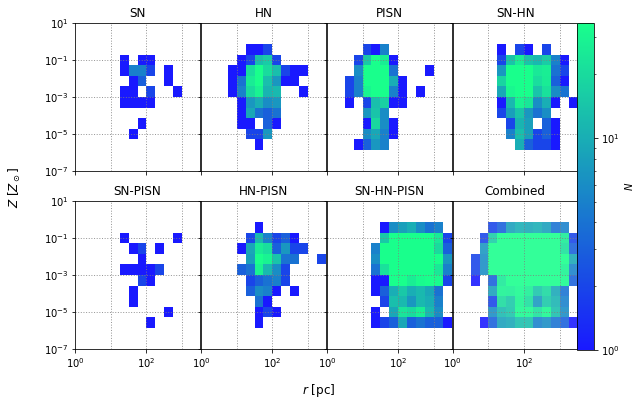

In [47]:
from matplotlib.colors import LogNorm
fig, ax = plt.subplots(2,4, figsize=(9,6), sharex=True, sharey=True)
ax= ax.flatten()
ybins = np.logspace(-7, 1, 15)
xbins = np.logspace(0, 3.5, 15)
allrz = [[],[]]
im = []
for i, l in enumerate(labels):
    allrz[0]+=r_enrichers[i]
    allrz[1]+=p2metals[i]
    im.append(ax[i].hist2d(r_enrichers[i], p2metals[i], bins=[xbins,ybins], cmap = 'winter', norm=LogNorm(), label=l, alpha=0.9, vmin=1, vmax=35))
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_title(l)
im.append(ax[-1].hist2d(allrz[0], allrz[1], bins=[xbins,ybins], label=l, alpha=0.8, cmap='winter', norm=LogNorm(),vmin=1, vmax=35))
ax[-1].set_yscale('log')
ax[-1].set_xscale('log')
ax[-1].set_title("Combined")
for a in ax:
    a.hlines([1e-5, 1e-3, 0.1], 1,3e3, linestyle=':', color='tab:gray', alpha=0.8, linewidth=1)
    a.vlines([1e1, 1e2, 1e3], 1e-7, 10, linestyle=':', color='tab:gray', alpha=0.8, linewidth=1)
fig.supxlabel('$r$ [pc]')
fig.supylabel('$Z$ $[Z_\odot]$')
cax = fig.add_axes([0.9, 0.124, 0.025, 0.756])
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(wspace=0.01)
cb = fig.colorbar(im[2][3], cax=cax, label = '$N$')
plt.savefig('./images/sntype_rVz_2dhist.pdf', bbox_inches='tight')

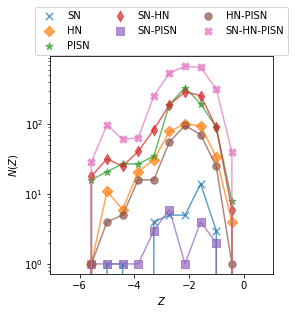

In [67]:
fig, ax = plt.subplots(figsize=(4,4))
zbins = np.linspace(-7,1,15)
plotbins = np.array([(zbins[i]+zbins[i-1])/2.0 for i in range(1, len(zbins))])
sumz = 0
markers = ['x','D','*','d', 's','o','X']
for z in p2metals:
    sumz += len(z)
for z, l, mark in zip(p2metals, labels, markers):
    hist, bins = np.histogram(np.log10(z), bins=zbins)
    ax.plot(plotbins, hist, linestyle = '-', alpha=0.7)
    ax.scatter(plotbins, hist, marker = mark , s=55, label = l, alpha=0.7)
ax.set_ylabel('$N(Z)$')
ax.set_xlabel('$Z$')
# ax.set_xlim(-6.2, -0.5)
# ax.set_ylim(4e-3, 5)
ax.set_yscale('log')
ax.legend(ncol=3, bbox_to_anchor=(1.09,1.25))
plt.savefig('images/p2_MDF_by_config.pdf')

In [4]:
simpaths = ['D:/starnet/simulation_data/phx512']
fouts = ['RD0980']
zbins = np.linspace(-7,3,100)
p2zs = None
for s, fout in zip(simpaths, fouts):
    ds = yt.load('%s/%s/%s'%(s, fout, fout))
    ds = add_particle_filters(ds)
    ad = ds.all_data()
    if p2zs:
        p2zs += [float(z) for z in ad['all_p3','metallicity_fraction'].to('Zsun')]
    else:
        p2zs = [float(z) for z in ad['all_p3', 'metallicity_fraction'].to('Zsun')]




yt : [INFO     ] 2021-08-25 16:00:21,362 Parameters: current_time              = 13.99556466352
yt : [INFO     ] 2021-08-25 16:00:21,362 Parameters: domain_dimensions         = [512 512 512]
yt : [INFO     ] 2021-08-25 16:00:21,362 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-08-25 16:00:21,363 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2021-08-25 16:00:21,364 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2021-08-25 16:00:21,364 Parameters: current_redshift          = 14.041244322549
yt : [INFO     ] 2021-08-25 16:00:21,365 Parameters: omega_lambda              = 0.6889
yt : [INFO     ] 2021-08-25 16:00:21,366 Parameters: omega_matter              = 0.3111
yt : [INFO     ] 2021-08-25 16:00:21,366 Parameters: omega_radiation           = 0
yt : [INFO     ] 2021-08-25 16:00:21,367 Parameters: hubble_constant           = 0.6766
Parsing Hierarchy : 100%|███████████████████████████████████████████████████| 139180/139180 [00:11

yt : [WARNING  ] 2021-08-25 16:00:40,738 The Derived Field ('index', 'cylindrical_r') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('index', 'cylindrical_radius') instead.
yt : [WARNING  ] 2021-08-25 16:00:40,752 The Derived Field ('index', 'disk_angle') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('index', 'spherical_theta') instead.
yt : [WARNING  ] 2021-08-25 16:00:40,760 The Derived Field ('index', 'height') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('index', 'cylindrical_z') instead.
yt : [WARNING  ] 2021-08-25 16:00:40,808 The Derived Field ('p2_stars', 'particle_cylindrical_velocity_theta') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('all', 'particle_velocity_cylindrical_theta') instead.
yt : [WARNING  ] 2021-08-25 16:00:40,812 The Derived Field ('p2_stars', 'particle_cylindrical_velocity_z') is deprecated as of yt v4.0.0 and will be removed in yt v4.1.0. Use ('all', 'particle_veloc